In [1]:
import anndata as ad
import scanpy as sc
import pandas as pd
import polars as pl
import pandas as pd
import os


from sklearn.datasets import load_breast_cancer, load_diabetes, load_iris
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import (
    accuracy_score,
    mean_absolute_error,
    mean_squared_error,
    root_mean_squared_error,
    r2_score,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.inspection import DecisionBoundaryDisplay

from sklearn.datasets import fetch_openml
from sklearn.preprocessing import LabelEncoder
from IPython.display import display, Markdown, Latex

# Baseline Imports
from xgboost import XGBClassifier, XGBRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

import torch

from tabpfn import TabPFNClassifier, TabPFNRegressor
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

if not torch.cuda.is_available():
    raise SystemError('GPU device not found. For fast training, please enable GPU. See section above for instructions.')

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [3]:
def run_scanpy(adata):
    sc.pp.pca(adata)
    sc.pp.neighbors(adata, n_neighbors=100)
    sc.tl.umap(adata)

In [4]:
adata = ad.read_h5ad("/home/jovyan/share/data/analyses/PLP/DP/extraction/specs5k_deepprofiler_wellagg_harmony.h5ad")

/home/jovyan/share/data/analyses/PLP/molt5/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [5]:
adata_filtered = ad.read_h5ad("/home/jovyan/share/data/analyses/PLP/DP/extraction/specs5k_deepprofiler_wellagg_SIGNIFICANT.h5ad")

## Show viability and grit/ cell count

In [58]:
check = adata_filtered.obs["%Induction"].unique()

In [61]:
check

array([ -6.70015173,  -6.359921  ,  -6.09957438, ..., 173.66276721,
       193.18288725, 207.37762058])

In [38]:
def plot_scatter_with_category(adata, x_col, y_col, category_col):
    """
    Generates a scatter plot with points colored based on a categorical column.

    Parameters:
        adata (AnnData): Annotated data object.
        x_col (str): Column name for x-axis.
        y_col (str): Column name for y-axis.
        category_col (str): Column name for coloring the points.
    """
    import seaborn as sns
    import matplotlib.pyplot as plt

    # Convert to DataFrame
    df = adata.obs[[x_col, y_col, category_col]].dropna()

    # Determine unique categories and assign colors automatically
    unique_categories = df[category_col].unique()
    palette = sns.color_palette("husl", len(unique_categories))  # Use a colorful palette
    category_palette = dict(zip(unique_categories, palette))

    # Create scatter plot
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        x=df[x_col],
        y=df[y_col],
        hue=df[category_col],  # Color points by category
        palette=category_palette,  # Automatically generated color palette
        alpha=0.7,  # Transparency for better visibility
        edgecolor="black"  # Add edge color to points
    )

    # Improve labels and title
    plt.xlabel(x_col, fontsize=12, fontweight="bold")
    plt.ylabel(y_col, fontsize=12, fontweight="bold")
    plt.title(f"{x_col} vs {y_col}\n(Number of data points: {len(df)})", fontsize=14, fontweight="bold")

    # Add grid for readability
    plt.grid(True, linestyle="--", alpha=0.5)

    # Show legend outside the plot for clarity
    plt.legend(title=category_col, bbox_to_anchor=(1.02, 1), loc='upper left')

    # Show the plot
    plt.show()

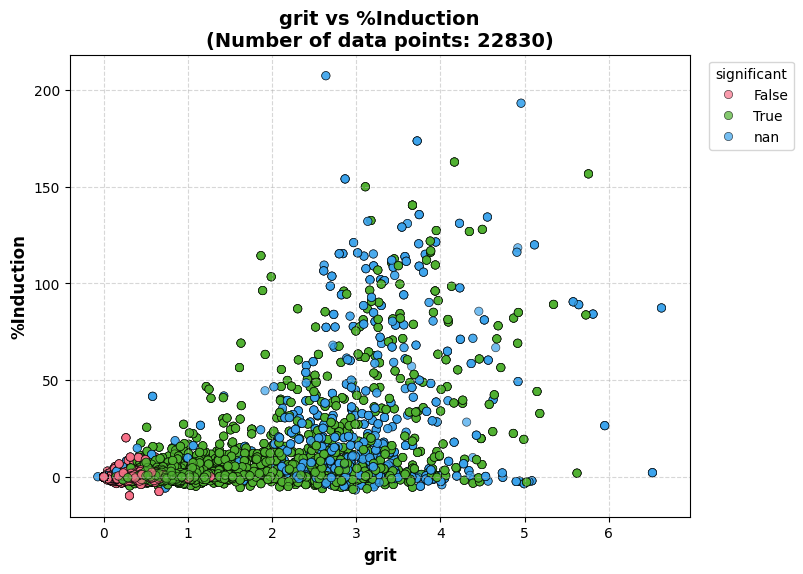

In [40]:
plot_scatter_with_category(adata, "grit", "%Induction", "significant")


# Split data

In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

def stratified_split_no_batch_overlap(
    adata, 
    label_col="label", 
    batch_col="batch_id", 
    test_size=0.2, 
    val_size=0.1, 
    random_seed=42, 
    obsm_key=None
):
    """
    Splits an AnnData object into train, validation, and test sets in a stratified way
    over the `label_col`, while ensuring that `batch_id` does not overlap between splits.
    Allows selecting a specific `obsm` key instead of `X` for feature extraction.

    Parameters:
        adata (AnnData): The input AnnData object.
        label_col (str): Column in `adata.obs` used for stratification.
        batch_col (str): Column in `adata.obs` that must not overlap between splits.
        test_size (float): Proportion of data to allocate to the test set.
        val_size (float): Proportion of data to allocate to the validation set **from remaining data**.
        random_seed (int): Random seed for reproducibility.
        obsm_key (str, optional): If provided, use this `obsm` key for feature extraction instead of `X`.

    Returns:
        train_df (pd.DataFrame): Train set as a DataFrame with features and labels.
        val_df (pd.DataFrame): Validation set as a DataFrame with features and labels.
        test_df (pd.DataFrame): Test set as a DataFrame with features and labels.
    """

    np.random.seed(random_seed)

    # Convert AnnData to Pandas DataFrame
    obs_df = adata.obs.copy()

    # Use specified `obsm` key if provided, otherwise use `X`
    if obsm_key is not None:
        if obsm_key not in adata.obsm.keys():
            raise ValueError(f"obsm_key '{obsm_key}' not found in AnnData.obsm. Available keys: {list(adata.obsm.keys())}")
        feature_matrix = adata.obsm[obsm_key]
        feature_names = ["Feature_" + str(col) for col in range(feature_matrix.shape[1])]
    else:
        feature_matrix = adata.X.toarray() if hasattr(adata.X, "toarray") else adata.X
        feature_names = ["Feature_" + str(col) for col in adata.var.index]

    # Convert features to a DataFrame
    feature_df = pd.DataFrame(feature_matrix, columns=feature_names, index=adata.obs.index)

    # Merge metadata with feature data
    df = pd.concat([obs_df, feature_df], axis=1)

    # Ensure batch_col and label_col exist
    if batch_col not in df.columns:
        raise ValueError(f"Batch column '{batch_col}' not found in AnnData object.")
    if label_col not in df.columns:
        raise ValueError(f"Label column '{label_col}' not found in AnnData object.")

    # Get unique batch-label combinations
    batch_label_groups = df[[batch_col, label_col]].drop_duplicates()

    # Step 1: Split batch-label groups into test and remaining
    train_groups, test_groups = train_test_split(
        batch_label_groups, stratify=batch_label_groups[label_col], test_size=test_size, random_state=random_seed
    )

    # Step 2: Split remaining into train and validation **properly**
    val_groups, train_groups = train_test_split(
        train_groups, stratify=train_groups[label_col], test_size=1 - (val_size / (1 - test_size)), random_state=random_seed
    )

    # Assign data based on batch-label splits
    train_df = df[df[batch_col].isin(train_groups[batch_col])].reset_index(drop=True)
    val_df = df[df[batch_col].isin(val_groups[batch_col])].reset_index(drop=True)
    test_df = df[df[batch_col].isin(test_groups[batch_col])].reset_index(drop=True)

    return train_df, val_df, test_df



In [48]:
train, val, test = stratified_split_no_batch_overlap(adata_filtered,label_col="label_simple", random_seed = 42, obsm_key= "X_pca_harmony")

In [49]:
train = pd.concat([train, val], axis = 0)

In [50]:
train_X = train[[feat for feat in train.columns if "Feature" in feat]]

In [51]:
train_y = train["label_simple"]

In [52]:
test_X = test[[feat for feat in test.columns if "Feature" in feat]]

In [53]:
test_y = test["label_simple"]

In [54]:
from sklearn.preprocessing import LabelEncoder

# Encode labels as integers
label_encoder = LabelEncoder()
train_y_encoded = label_encoder.fit_transform(train_y)
test_y_encoded = label_encoder.transform(test_y) 

In [55]:
from sklearn.model_selection import GridSearchCV
def grid_search_rf_xgb(train_X, train_y):
    """Performs Grid Search for Random Forest and XGBoost"""
    # Define parameter grids
    rf_params = {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10]
    }

    xgb_params = {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 6, 10],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 1.0]
    }

    # Random Forest Grid Search
    rf = RandomForestClassifier(random_state=42)
    rf_grid = GridSearchCV(rf, rf_params, scoring='f1_weighted', cv=3, n_jobs=-1, verbose=2)
    rf_grid.fit(train_X, train_y)
    best_rf_params = rf_grid.best_params_
    print("Best RF Parameters:", best_rf_params)

    # XGBoost Grid Search
    xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
    xgb_grid = GridSearchCV(xgb, xgb_params, scoring='f1_weighted', cv=3, n_jobs=-1, verbose=2)
    xgb_grid.fit(train_X, train_y)
    best_xgb_params = xgb_grid.best_params_
    print("Best XGB Parameters:", best_xgb_params)

    return best_rf_params, best_xgb_params

In [6]:
import gc

def print_gpu_memory():
    allocated = torch.cuda.memory_allocated() / (1024**2)
    cached = torch.cuda.memory_reserved() / (1024**2)
    print(f"Allocated: {allocated:.2f} MB")
    print(f"Cached: {cached:.2f} MB")

# Before clearing the cache
print("Before clearing cache:")
print_gpu_memory()

# Clearing cache
gc.collect()
torch.cuda.empty_cache()

# After clearing the cache
print("\nAfter clearing cache:")
print_gpu_memory()

Before clearing cache:
Allocated: 0.00 MB
Cached: 0.00 MB

After clearing cache:
Allocated: 0.00 MB
Cached: 0.00 MB


In [ ]:
best_rf_params, best_xgb_params = grid_search_rf_xgb(train_X, train_y_encoded)


In [7]:
import os
os.environ["SCIPY_ARRAY_API"] = "1"

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from tabpfn import TabPFNRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler

# Function for stratified splitting with no batch overlap
def stratified_split_no_batch_overlap(
    adata, 
    target_col="target", 
    batch_col="batch_id", 
    test_size=0.2, 
    val_size=0.1, 
    random_seed=42, 
    obsm_key=None
):
    np.random.seed(random_seed)

    obs_df = adata.obs.copy()

    # Use specified `obsm` key if provided, otherwise use `X`
    if obsm_key is not None:
        if obsm_key not in adata.obsm.keys():
            raise ValueError(f"obsm_key '{obsm_key}' not found in AnnData.obsm. Available keys: {list(adata.obsm.keys())}")
        feature_matrix = adata.obsm[obsm_key]
        feature_names = ["Feature_" + str(col) for col in range(feature_matrix.shape[1])]
    else:
        feature_matrix = adata.X.toarray() if hasattr(adata.X, "toarray") else adata.X
        feature_names = ["Feature_" + str(col) for col in adata.var.index]

    feature_df = pd.DataFrame(feature_matrix, columns=feature_names, index=adata.obs.index)
    df = pd.concat([obs_df, feature_df], axis=1)

    if batch_col not in df.columns:
        raise ValueError(f"Batch column '{batch_col}' not found in AnnData object.")
    if target_col not in df.columns:
        raise ValueError(f"Target column '{target_col}' not found in AnnData object.")

    batch_target_groups = df[[batch_col, target_col]].drop_duplicates()

    train_groups, test_groups = train_test_split(
        batch_target_groups, test_size=test_size, random_state=random_seed
    )

    val_groups, train_groups = train_test_split(
        train_groups, test_size=1 - (val_size / (1 - test_size)), random_state=random_seed
    )
    compound_col = "batch_id"  # Adjust if compound ID is named differently

    if compound_col not in df.columns:
        raise ValueError(f"Compound column '{compound_col}' not found in AnnData object.")

    train_df = df[df[batch_col].isin(train_groups[batch_col])].reset_index(drop=True)
    val_df = df[df[batch_col].isin(val_groups[batch_col])].reset_index(drop=True)
    test_df = df[df[batch_col].isin(test_groups[batch_col])].reset_index(drop=True)


    return train_df, val_df, test_df

# Training and Evaluation for Regression
def evaluate_regression_models(adata, obsm_keys=["X", "X_pca", "X_pca_harmony"], target_col="target", batch_col="batch_id", undersample=False):
    results = []
    predictions = []

    for split_seed in range(5):  # 5 random splits
        for obsm_key in obsm_keys:
            print(f"Evaluating for split seed {split_seed} and features {obsm_key}")

            # Perform stratified split
            train, val, test = stratified_split_no_batch_overlap(
                adata, target_col=target_col, batch_col=batch_col, random_seed=split_seed, obsm_key=obsm_key
            )

            # Combine train and validation sets
            train = pd.concat([train, val], axis=0)

            # Extract features, target, and batch information
            train_X = train[[feat for feat in train.columns if "Feature" in feat]]
            train_y = train[target_col]
            train_batches = train[batch_col]  # Retain batch info

            test_X = test[[feat for feat in test.columns if "Feature" in feat]]
            test_y = test[target_col]
            test_batches = test[batch_col]  # Retain batch info

            train_X = train_X.astype(np.float32)
            train_y = train_y.astype(np.float32)
            test_X = test_X.astype(np.float32)
            test_y = test_y.astype(np.float32)

            # Optional undersampling
            if undersample:
                undersampler = RandomUnderSampler(sampling_strategy="auto", random_state=42)
                train_X, train_y = undersampler.fit_resample(train_X, train_y)

            # Define regression models
            models = {
                'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
                'XGBoost': XGBRegressor(n_estimators=100, random_state=42),
                'TabPFN': TabPFNRegressor(ignore_pretraining_limits=True, random_state=42),
            }

            # Train and evaluate models
            for name, model in models.items():
                print(f"Training {name} on {obsm_key}")

                model.fit(train_X, train_y)
                test_preds = model.predict(test_X)

                # Compute metrics
                test_rmse = np.sqrt(mean_squared_error(test_y, test_preds))  # RMSE
                test_r2 = r2_score(test_y, test_preds)  # R² Score
                test_mae = mean_absolute_error(test_y, test_preds)  # MAE

                # Adjusted R² Calculation
                n = test_X.shape[0]  # Number of samples
                p = test_X.shape[1]  # Number of predictors (features)
                adjusted_r2 = 1 - ((1 - test_r2) * (n - 1) / (n - p - 1))

                # Normalize RMSE using the range of target values
                target_range = test_y.max() - test_y.min()
                normalized_rmse = test_rmse / target_range if target_range != 0 else np.nan

                results.append({
                    "Model": name,
                    "Features": obsm_key,
                    "Seed": split_seed,
                    "RMSE": test_rmse,
                    "Normalized RMSE": normalized_rmse,
                    "Adjusted R²": adjusted_r2,
                    "MAE": test_mae,
                })

                # Store predictions including batch_id
                preds_df = pd.DataFrame({
                    "batch_id": test_batches.values,  # Add batch info
                    "True Value": test_y,
                    "Predicted Value": test_preds,
                    "Model": name,
                    "Features": obsm_key,
                    "Seed": split_seed
                })
                predictions.append(preds_df)

    return pd.DataFrame(results), pd.concat(predictions)

    
# Example usage
results_df_filtered_simple, predictions_df_filtered_simple = evaluate_regression_models(
    adata_filtered, obsm_keys=["X_pca_harmony"], target_col="%Induction", batch_col="batch_id", undersample=False
)

#results_df_simple, predictions_df_simple = evaluate_regression_models(
#    adata, obsm_keys=["X_pca", "X_pca_harmony"], target_col="%Induction", batch_col="batch_id", undersample=False
#)

Evaluating for split seed 0 and features X_pca_harmony
Training RandomForest on X_pca_harmony
Training XGBoost on X_pca_harmony
Training TabPFN on X_pca_harmony


/home/jovyan/share/data/analyses/PLP/molt5/lib/python3.10/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/jovyan/share/data/analyses/PLP/molt5/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jovyan/share/data/analyses/PLP/molt5/lib/python3.10/site-packages/tabpfn/regressor.py:425: UserWarning: Number of samples 10176 is greater than the maximum Number of samples 10000 supported by the model. You may see degraded performance.
  X, y, feature_names_in, n_features_in = validate_Xy_fit(
/home/jovyan/share/data/analyses/PLP/molt5/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_fin

Evaluating for split seed 1 and features X_pca_harmony
Training RandomForest on X_pca_harmony
Training XGBoost on X_pca_harmony
Training TabPFN on X_pca_harmony


/home/jovyan/share/data/analyses/PLP/molt5/lib/python3.10/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/jovyan/share/data/analyses/PLP/molt5/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jovyan/share/data/analyses/PLP/molt5/lib/python3.10/site-packages/tabpfn/regressor.py:425: UserWarning: Number of samples 10186 is greater than the maximum Number of samples 10000 supported by the model. You may see degraded performance.
  X, y, feature_names_in, n_features_in = validate_Xy_fit(
/home/jovyan/share/data/analyses/PLP/molt5/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_fin

Evaluating for split seed 2 and features X_pca_harmony
Training RandomForest on X_pca_harmony
Training XGBoost on X_pca_harmony
Training TabPFN on X_pca_harmony


/home/jovyan/share/data/analyses/PLP/molt5/lib/python3.10/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/jovyan/share/data/analyses/PLP/molt5/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jovyan/share/data/analyses/PLP/molt5/lib/python3.10/site-packages/tabpfn/regressor.py:425: UserWarning: Number of samples 10204 is greater than the maximum Number of samples 10000 supported by the model. You may see degraded performance.
  X, y, feature_names_in, n_features_in = validate_Xy_fit(
/home/jovyan/share/data/analyses/PLP/molt5/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_fin

Evaluating for split seed 3 and features X_pca_harmony
Training RandomForest on X_pca_harmony
Training XGBoost on X_pca_harmony
Training TabPFN on X_pca_harmony


/home/jovyan/share/data/analyses/PLP/molt5/lib/python3.10/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/jovyan/share/data/analyses/PLP/molt5/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jovyan/share/data/analyses/PLP/molt5/lib/python3.10/site-packages/tabpfn/regressor.py:425: UserWarning: Number of samples 10181 is greater than the maximum Number of samples 10000 supported by the model. You may see degraded performance.
  X, y, feature_names_in, n_features_in = validate_Xy_fit(
/home/jovyan/share/data/analyses/PLP/molt5/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_fin

Evaluating for split seed 4 and features X_pca_harmony
Training RandomForest on X_pca_harmony
Training XGBoost on X_pca_harmony
Training TabPFN on X_pca_harmony


/home/jovyan/share/data/analyses/PLP/molt5/lib/python3.10/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/jovyan/share/data/analyses/PLP/molt5/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jovyan/share/data/analyses/PLP/molt5/lib/python3.10/site-packages/tabpfn/regressor.py:425: UserWarning: Number of samples 10177 is greater than the maximum Number of samples 10000 supported by the model. You may see degraded performance.
  X, y, feature_names_in, n_features_in = validate_Xy_fit(
/home/jovyan/share/data/analyses/PLP/molt5/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_fin

In [9]:
predictions_df_filtered_simple

,batch_id,True Value,Predicted Value,Model,Features,Seed
0,BJ1896126,-1.063064,2.632205,RandomForest,X_pca_harmony,0
1,BJ1896453,3.177694,11.505985,RandomForest,X_pca_harmony,0
2,BJ1896511,-0.950607,0.475623,RandomForest,X_pca_harmony,0
3,BJ1894010,-0.633218,0.345650,RandomForest,X_pca_harmony,0
4,BJ1896491,2.036367,2.136948,RandomForest,X_pca_harmony,0
...,...,...,...,...,...,...
2547,BJ1898625,27.763945,28.352055,TabPFN,X_pca_harmony,4
2548,BJ1894239,2.952961,3.905014,TabPFN,X_pca_harmony,4
2549,BJ1895533,-0.380099,-0.005352,TabPFN,X_pca_harmony,4
2550,BJ1896209,0.102424,0.789306,TabPFN,X_pca_harmony,4


In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_regression_comparison(results_dfs, filtering_levels):
    """
    Plots regression model performance across different feature sets and filtering levels.

    Parameters:
        results_dfs (list of pd.DataFrame): List of results DataFrames to compare.
        filtering_levels (list of str): Labels for each filtering level.
    """

    # Ensure proper filtering labels
    if len(results_dfs) == 1:
        results_dfs[0]["Filtering"] = filtering_levels[0]
        combined_df = results_dfs[0]
    else:
        combined_df = pd.concat([
            df.assign(Filtering=filtering_levels[i]) for i, df in enumerate(results_dfs)
        ])

    # Define regression metrics
    metrics = ["RMSE", "MAE", "Adjusted R²", "Normalized RMSE"]
    metric_titles = {
        "RMSE": "Root Mean Squared Error (RMSE)",
        "Normalized RMSE": "Normalizedd Root Mean Squared Error (RMSE)",
        "MAE": "Mean Absolute Error (MAE)",
        "Adjusted R²": "Adjusted R² Score"
    }

    # Define feature color map
    feature_palette = {
        "Full Features": "C0",
        "X_pca": "C1",
        "X_pca_harmony": "C2"
    }

    # Generate plots for each metric
    for metric in metrics:
        g = sns.catplot(
            data=combined_df,
            x="Model",
            y=metric,
            hue="Features",
            col="Filtering",  # Separate plots for filtering levels
            kind="bar",
            palette=feature_palette,
            height=5, aspect=1.2,
            dodge=True  # Keep feature sets separate
        )

        g.set_axis_labels("Model", metric_titles[metric])
        g.set_titles("{col_name}")  # Use filtering level as title

        # Adjust y-axis limits based on the metric
        if metric == "R2 Score":
            g.set(ylim=(max(-1.0, combined_df[metric].min() * 0.98), min(1.0, combined_df[metric].max() * 1.02)))
        else:
            g.set(ylim=(combined_df[metric].min() * 0.98, combined_df[metric].max() * 1.02))

        # Move legend outside
        g._legend.set_bbox_to_anchor((1.02, 1))
        g._legend.set_title("Features")

        plt.tight_layout()
        plt.show()

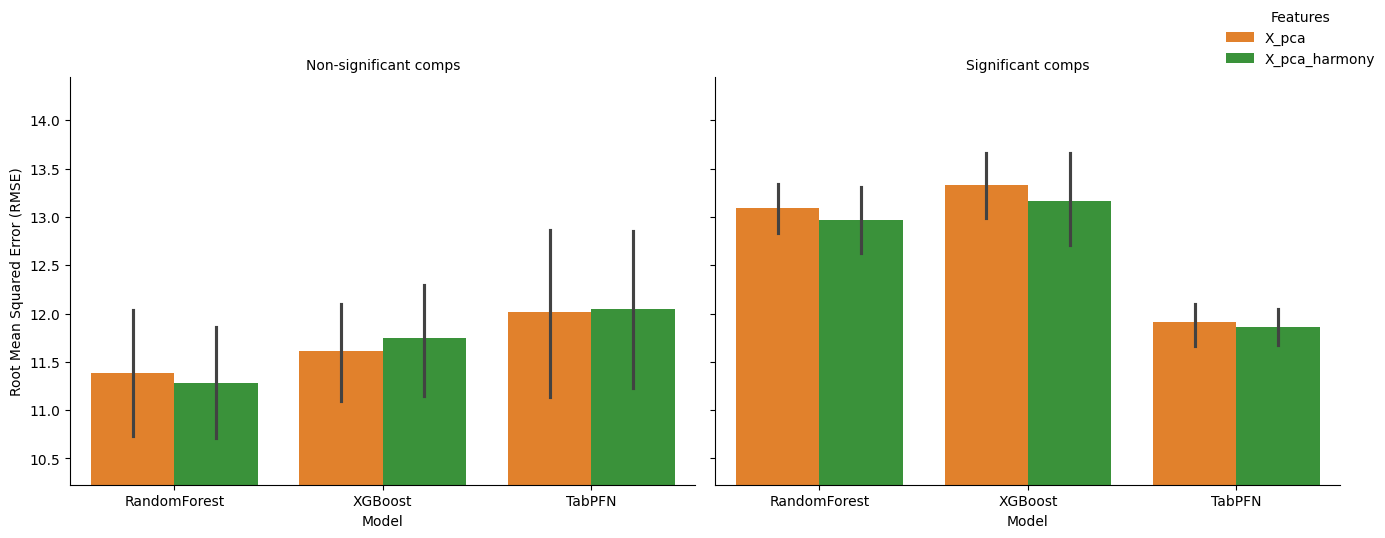

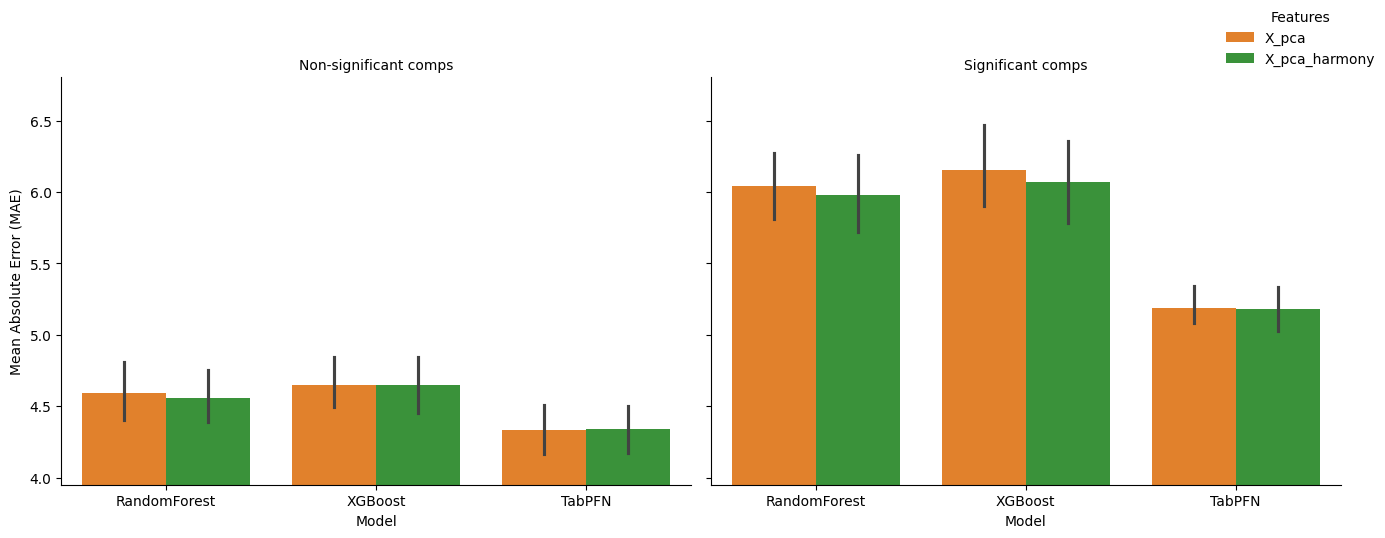

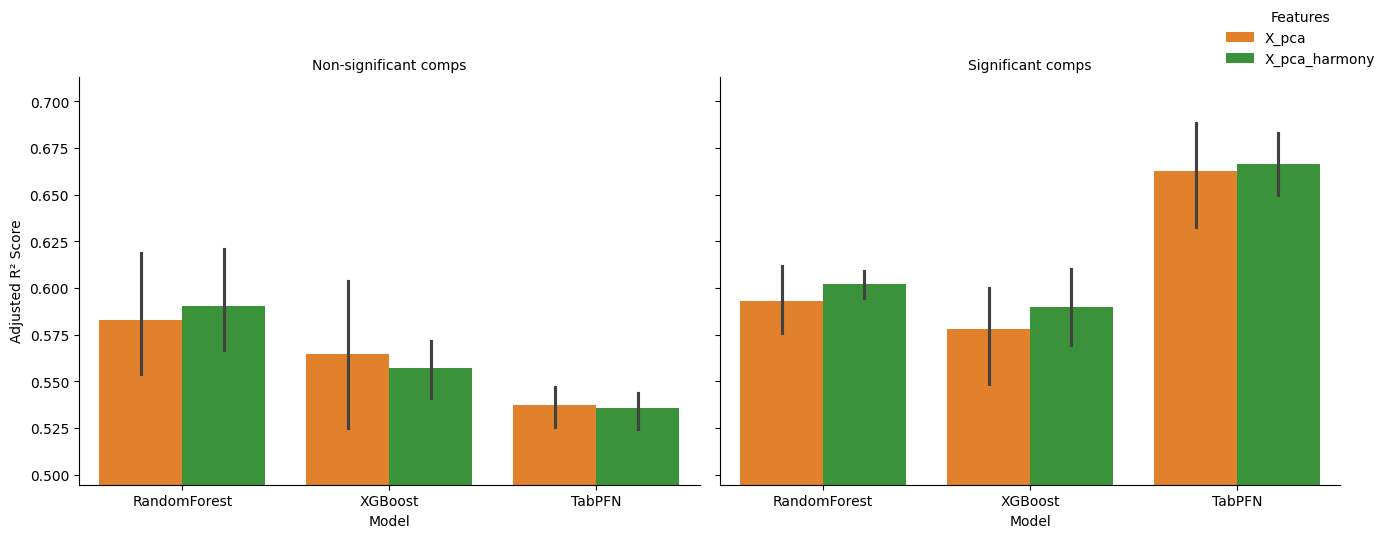

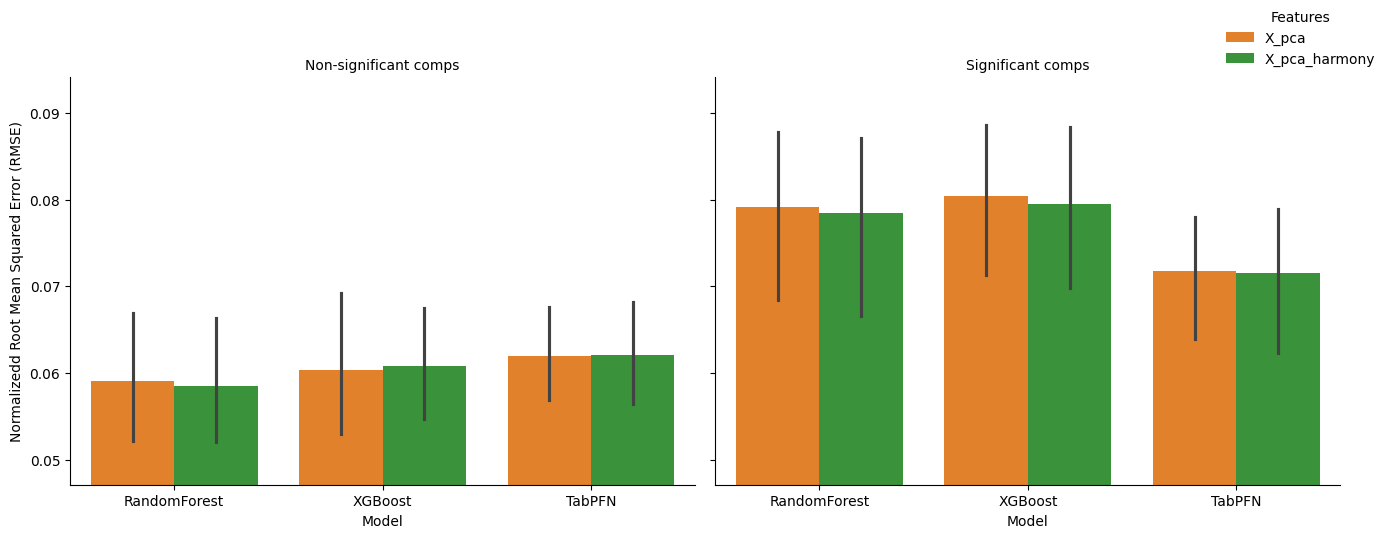

In [8]:
plot_regression_comparison([results_df_simple, results_df_filtered_simple],  ["Non-significant comps", "Significant comps"])

In [12]:
import torch
torch.cuda.empty_cache()
torch.cuda.reset_max_memory_allocated()


/home/jovyan/share/data/analyses/petter/FeatureExtractionBenchmark/benchmark_env/lib/python3.11/site-packages/torch/cuda/memory.py:391: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


In [ ]:
results_df_filtered, predictions_df_filtered = evaluate_models(adata_filtered, obsm_keys=["X_pca", "X_pca_harmony"], label_col="label", batch_col="batch_id", undersample = False)
results_df_filtered_under, predictions_df_filtered_under = evaluate_models(adata_filtered, obsm_keys=["X_pca", "X_pca_harmony"], label_col="label", batch_col="batch_id", undersample = True)

In [36]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrices(predictions):
    """
    Plots confusion matrices averaged over different seeds and reports values as percentages
    with standard deviation annotated as ± in each cell.
    
    Parameters:
        predictions (pd.DataFrame): A DataFrame containing:
            - 'True Label': Actual labels
            - 'Predicted Label': Predicted labels
            - 'Model': Model name
            - 'Features': Feature type used
            - 'Seed': The random seed used in training
    """

    unique_models = predictions["Model"].unique()
    unique_features = predictions["Features"].unique()
    
    for model in unique_models:
        for feature in unique_features:
            subset = predictions[(predictions["Model"] == model) & (predictions["Features"] == feature)]
            if subset.empty:
                continue

            # Get unique labels
            labels = np.unique(np.concatenate([subset["True Label"], subset["Predicted Label"]]))

            # Create confusion matrices for each seed
            seed_matrices = []
            for seed in subset["Seed"].unique():
                seed_subset = subset[subset["Seed"] == seed]
                cm = confusion_matrix(seed_subset["True Label"], seed_subset["Predicted Label"], labels=labels)
                seed_matrices.append(cm)

            # Compute mean and standard deviation confusion matrix across seeds
            mean_cm = np.mean(seed_matrices, axis=0)
            std_cm = np.std(seed_matrices, axis=0)

            # Convert to percentage
            mean_cm_percent = mean_cm / mean_cm.sum(axis=1, keepdims=True) * 100  # Normalize by row sum
            std_cm_percent = std_cm / mean_cm.sum(axis=1, keepdims=True) * 100  # Normalize std by row sum

            # Create formatted annotations with mean ± std
            annotations = np.array([
                [f"{mean_cm_percent[i, j]:.1f}±{std_cm_percent[i, j]:.1f}" for j in range(mean_cm.shape[1])]
                for i in range(mean_cm.shape[0])
            ])

            # Plot confusion matrix with percentages and standard deviation
            plt.figure(figsize=(6, 5))
            ax = sns.heatmap(
                mean_cm_percent, annot=annotations, fmt="", cmap="Blues",
                xticklabels=labels, yticklabels=labels, linewidths=0.5, linecolor="gray"
            )

            plt.xlabel("Predicted Label")
            plt.ylabel("True Label")
            plt.title(f"Confusion Matrix (Mean % ± SD)\n{model} ({feature})")

            plt.show()

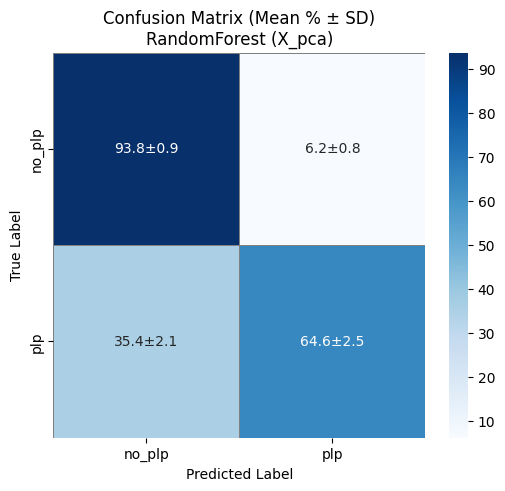

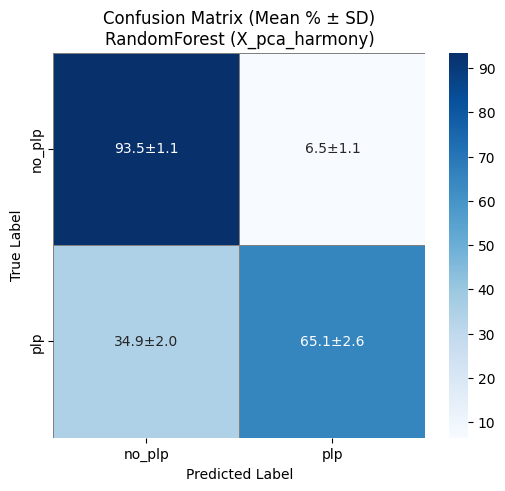

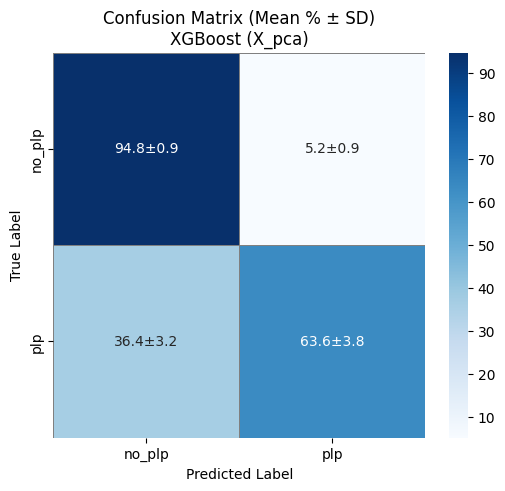

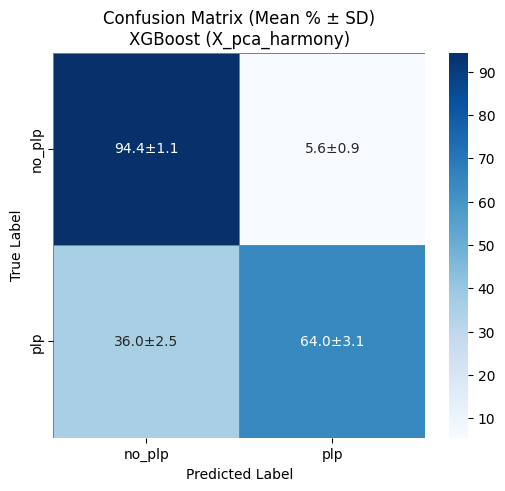

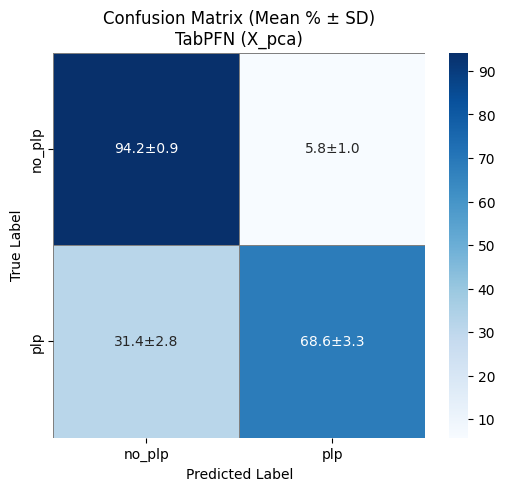

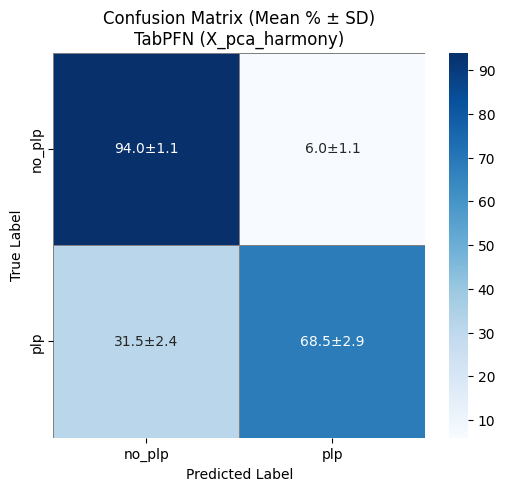

In [63]:
plot_confusion_matrices(predictions_df_filtered_simple)


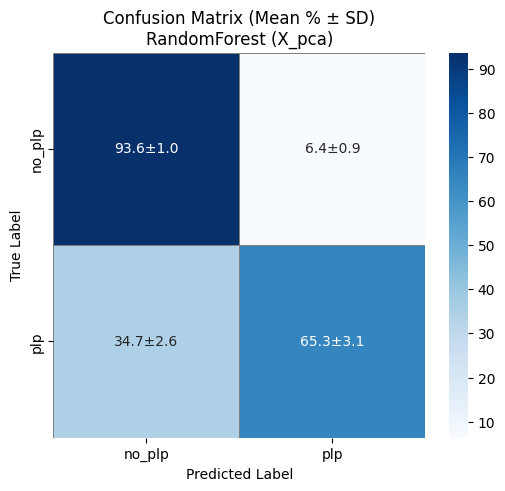

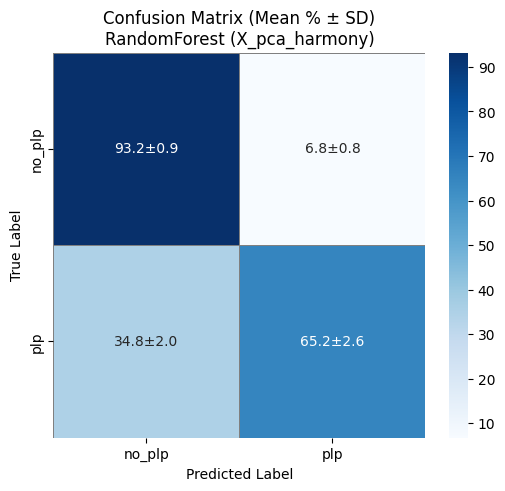

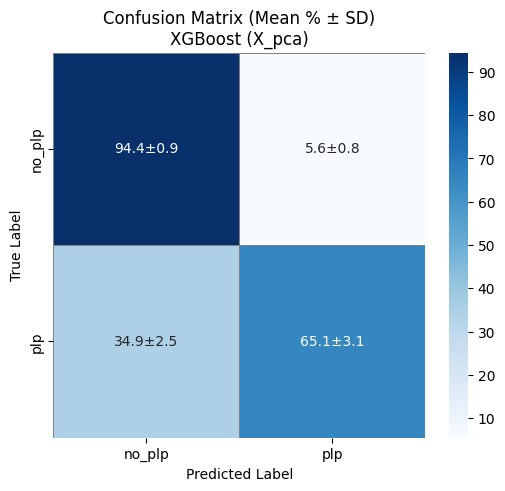

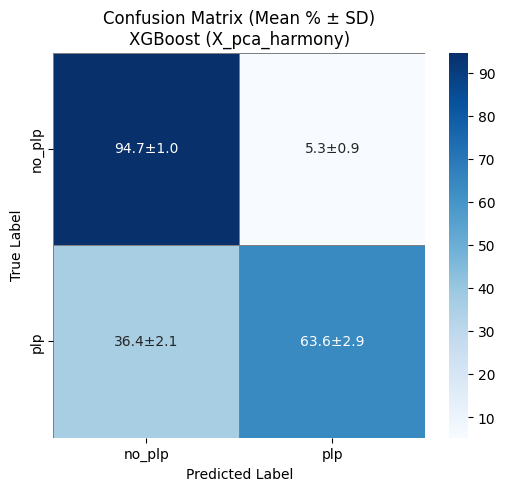

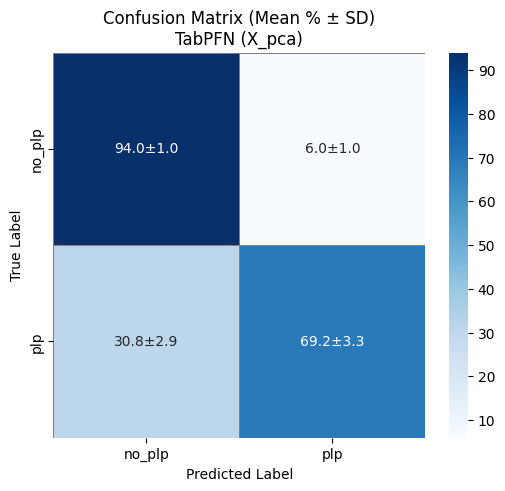

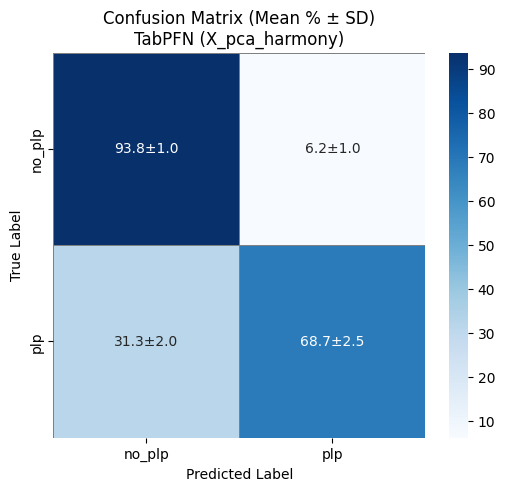

In [64]:
plot_confusion_matrices(predictions_df_filtered_under_simple)


In [10]:
predictions_df_filtered_simple.to_csv("filtered_reg_res.csv")

In [13]:
predictions_df_simple.to_csv("full_reg_res.csv")

In [15]:
results_df_simple.to_csv("full_reg_metrics.csv")

In [16]:
results_df_filtered_simple.to_csv("filterd_reg_metrics.csv")

In [2]:
predictions_df_filtered = pd.read_csv("filtered_reg_res.csv")
results_df_filtered = pd.read_csv("filterd_reg_metrics.csv")

In [62]:
predictions_df = pd.read_csv("full_reg_res.csv")


In [12]:
predictions_df_filtered_simple

,batch_id,True Value,Predicted Value,Model,Features,Seed
0,BJ1896126,-1.063064,2.632205,RandomForest,X_pca_harmony,0
1,BJ1896453,3.177694,11.505985,RandomForest,X_pca_harmony,0
2,BJ1896511,-0.950607,0.475623,RandomForest,X_pca_harmony,0
3,BJ1894010,-0.633218,0.345650,RandomForest,X_pca_harmony,0
4,BJ1896491,2.036367,2.136948,RandomForest,X_pca_harmony,0
...,...,...,...,...,...,...
2547,BJ1898625,27.763945,28.352055,TabPFN,X_pca_harmony,4
2548,BJ1894239,2.952961,3.905014,TabPFN,X_pca_harmony,4
2549,BJ1895533,-0.380099,-0.005352,TabPFN,X_pca_harmony,4
2550,BJ1896209,0.102424,0.789306,TabPFN,X_pca_harmony,4


/tmp/ipykernel_111080/1525434966.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_avg = df_filtered.groupby(["Model", "batch_id"]).agg({
/home/jovyan/share/data/analyses/PLP/molt5/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/jovyan/share/data/analyses/PLP/molt5/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/jovyan/share/data/analyses/PLP/molt5/lib/python3.10/site-packages/se

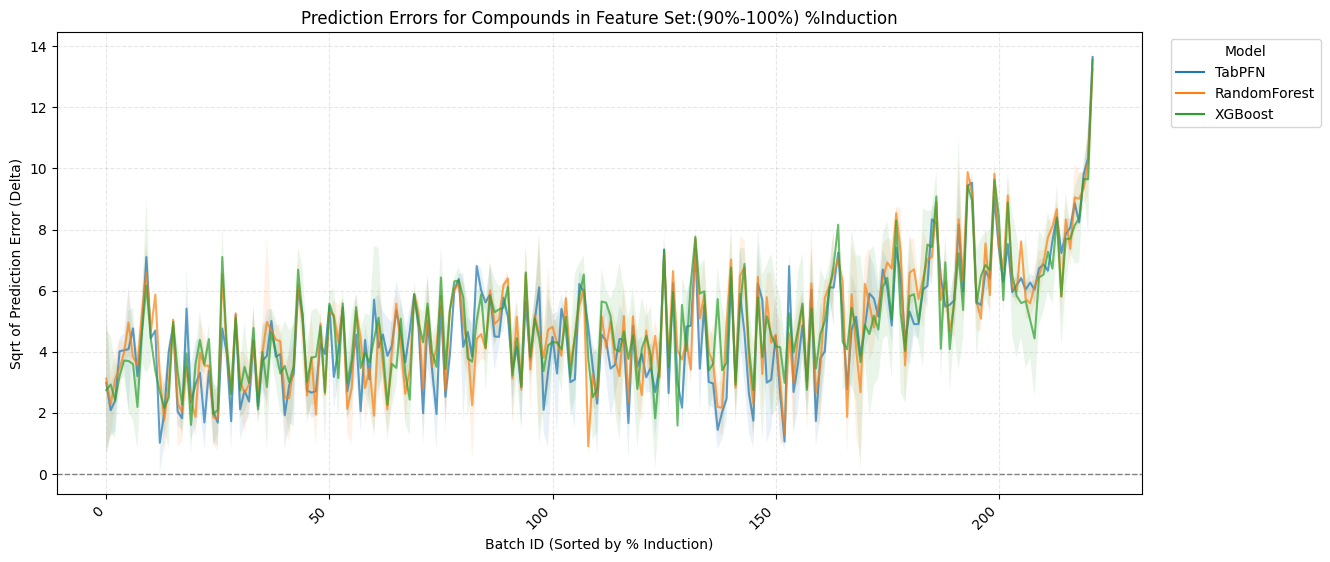

/home/jovyan/share/data/analyses/PLP/molt5/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/jovyan/share/data/analyses/PLP/molt5/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/jovyan/share/data/analyses/PLP/molt5/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jovyan/share/data/analyses/PLP/molt5/lib/python3.10/site-packa

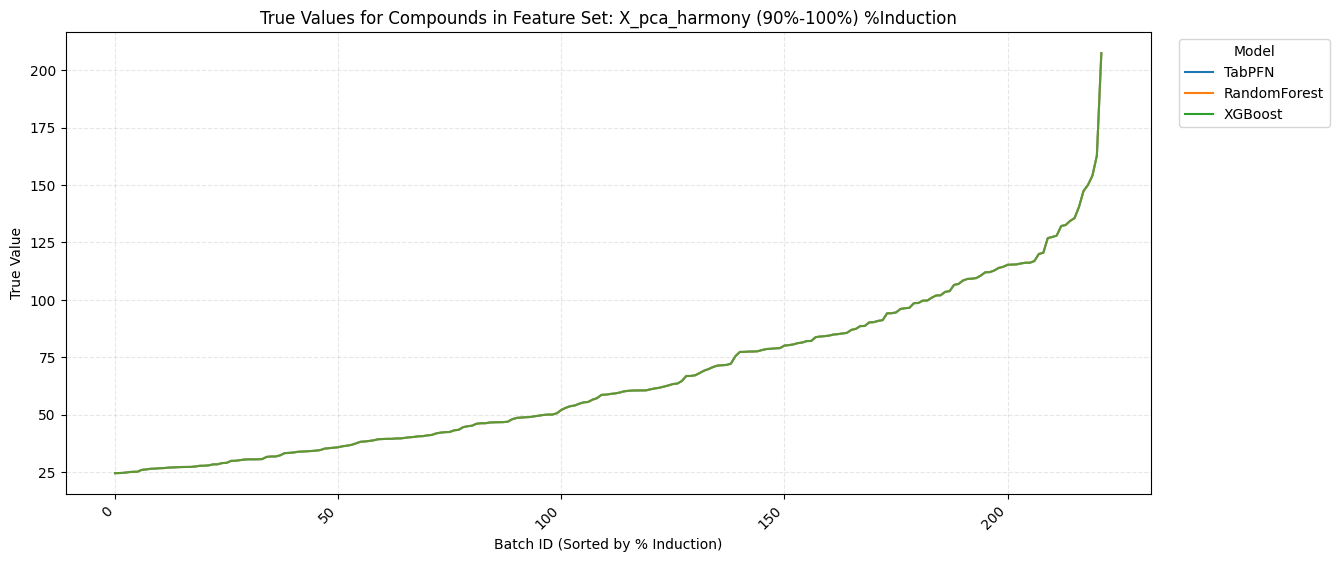

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_compounds_with_errors(df, features_filter="X_pca_harmony", percent_range=(0, 100)): 
    """
    Plots the prediction errors (Delta) and True Values for all compounds using line plots,
    with models in different colors. The x-axis is sorted by the true % induction.
    A shaded ribbon represents the standard deviation of the splits for prediction errors.

    Parameters:
        df (pd.DataFrame): DataFrame containing true values, predictions, models, and features.
        features_filter (str): Feature type to filter before plotting (e.g., "X_pca_harmony").
        percent_range (tuple): A range (min_percent, max_percent) to filter a percentage range of % induction.
    """
    
    df_filtered = df[df["Features"] == features_filter].copy()

    # Compute Prediction Error (Delta)
    df_filtered["Delta"] = np.sqrt(np.abs(df_filtered["Predicted Value"] - df_filtered["True Value"]))
    
    # Group by Model and batch_id, then compute mean and standard deviation across Seeds
    df_avg = df_filtered.groupby(["Model", "batch_id"]).agg({
        "Delta": ["mean", "std"],
        "True Value": "mean"  # True values don't have std deviation
    }).reset_index()
    df_avg.columns = ["Model", "batch_id", "Delta_mean", "Delta_std", "True_mean"]
    
    # Sort batch_id based on True_mean
    df_avg = df_avg.sort_values("True_mean").reset_index(drop=True)
    
    # Apply percentage-based filtering
    min_val, max_val = df_avg["True_mean"].quantile([percent_range[0] / 100, percent_range[1] / 100])
    df_avg = df_avg[(df_avg["True_mean"] >= min_val) & (df_avg["True_mean"] <= max_val)]
    
    # Assign a unique sequential index per batch_id after filtering
    df_avg["Sorted_Index"] = pd.factorize(df_avg["batch_id"])[0]  # Ensure unique ordered indices
    
    plt.figure(figsize=(14, 6))
    
    # Create a line plot for Delta with shaded standard deviation
    sns.lineplot(data=df_avg, x="Sorted_Index", y="Delta_mean", hue="Model", alpha=0.7)
    for model in df_avg["Model"].unique():
        model_data = df_avg[df_avg["Model"] == model]
        plt.fill_between(model_data["Sorted_Index"], model_data["Delta_mean"] - model_data["Delta_std"],
                         model_data["Delta_mean"] + model_data["Delta_std"], alpha=0.1)
    
    # Format Plot
    plt.xticks(rotation=45, ha="right", fontsize=10)
    plt.axhline(0, linestyle="--", color="gray", linewidth=1)
    plt.xlabel("Batch ID (Sorted by % Induction)")
    plt.ylabel("Sqrt of Prediction Error (Delta)")
    plt.title(f"Prediction Errors for Compounds in Feature Set: ({percent_range[0]}%-{percent_range[1]}%) %Induction")
    plt.legend(title="Model", bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.show()
    
    # Plot True Values without shaded standard deviation
    plt.figure(figsize=(14, 6))
    sns.lineplot(data=df_avg, x="Sorted_Index", y="True_mean", hue="Model", alpha=0.7)
    
    plt.xticks(rotation=45, ha="right", fontsize=10)
    plt.xlabel("Batch ID (Sorted by % Induction)")
    plt.ylabel("True Value")
    plt.title(f"True Values for Compounds in Feature Set: ({percent_range[0]}%-{percent_range[1]}%) %Induction")
    plt.legend(title="Model", bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.show()



plot_compounds_with_errors(predictions_df_filtered_simple, percent_range = (90,100))

/tmp/ipykernel_111080/3016738776.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_avg = df_filtered.groupby(["Model", "batch_id", "PLP_Category_True", "Prediction_Correct"]).agg({
/home/jovyan/share/data/analyses/PLP/molt5/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/jovyan/share/data/analyses/PLP/molt5/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/jovyan/share/data/analyse

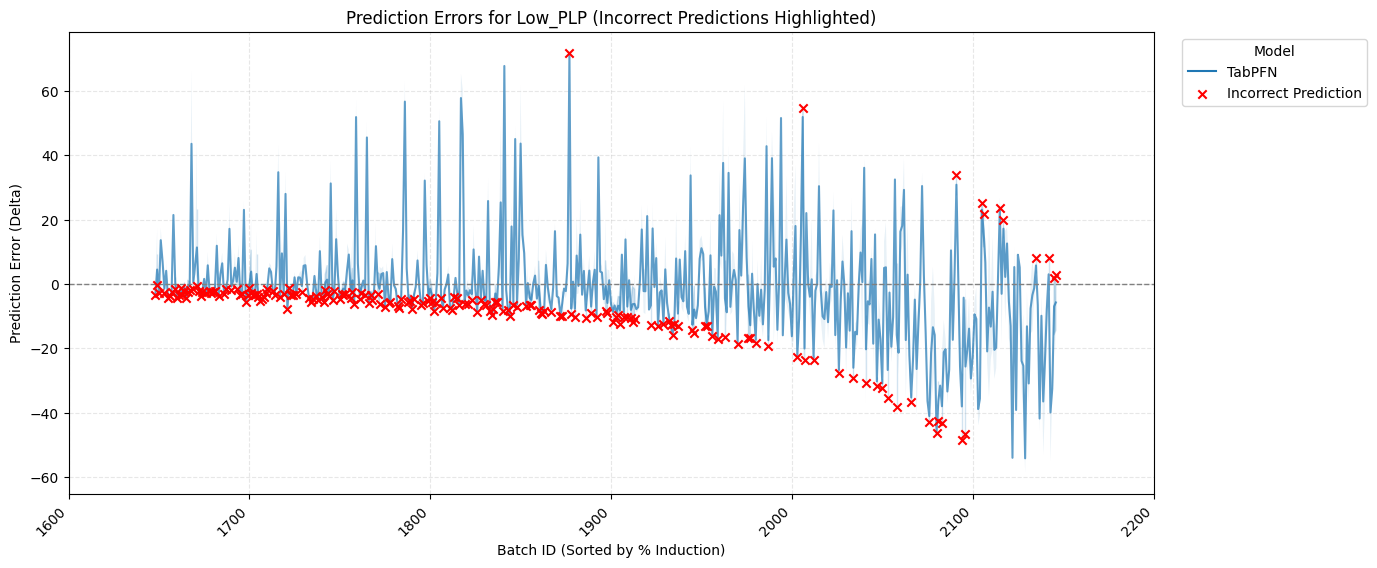

In [50]:
def plot_compounds_with_errors(df, features_filter="X_pca_harmony", percent_range=(0, 100), y_range=None, categories_to_display="all", models_to_display="all"): 
    """
    Plots the prediction errors (Delta) and True Values for all compounds using line plots,
    with models in different colors. The x-axis represents batch_id but is sorted by the true % induction.
    A shaded ribbon represents the standard deviation of the splits for prediction errors.
    Additionally, incorrect predictions are flagged using statistical process control-style markers.

    Parameters:
        df (pd.DataFrame): DataFrame containing true values, predictions, models, and features.
        features_filter (str): Feature type to filter before plotting (e.g., "X_pca_harmony").
        percent_range (tuple): A range (min_percent, max_percent) to filter a percentage range of % induction.
        y_range (tuple): Optional tuple (min, max) to set y-axis limits.
        categories_to_display (list or str): List of PLP categories to display or "all" for all categories.
        models_to_display (list or str): List of models to display or "all" for all models.
    """
    
    # Filter DataFrame for the specified feature type
    df_filtered = df[df["Features"] == features_filter].copy()

    # Compute Prediction Error (Delta)
    df_filtered["Delta"] = df_filtered["Predicted Value"] - df_filtered["True Value"]
    
    # Define PLP response categories
    def categorize_plp(response):
        if response > 80:
            return "High_PLP_10uM"
        elif response < 4.53:
            return "No_PLP"
        elif 4.53 <= response < 80:
            return "Low_PLP"
        else:
            return "High_PLP_10uM_nontoxic"
    
    df_filtered["PLP_Category_True"] = df_filtered["True Value"].apply(categorize_plp)
    df_filtered["PLP_Category_Predicted"] = df_filtered["Predicted Value"].apply(categorize_plp)
    
    # Determine whether the prediction matches the true category
    df_filtered["Prediction_Correct"] = df_filtered["PLP_Category_True"] == df_filtered["PLP_Category_Predicted"]
    
    # Filter by selected models
    if models_to_display != "all":
        df_filtered = df_filtered[df_filtered["Model"].isin(models_to_display)]
    
    # Group by Model and batch_id, then compute mean and standard deviation across Seeds
    df_avg = df_filtered.groupby(["Model", "batch_id", "PLP_Category_True", "Prediction_Correct"]).agg({
        "Delta": ["mean", "std"],
        "True Value": "mean"  # True values don't have std deviation
    }).reset_index()
    df_avg.columns = ["Model", "batch_id", "PLP_Category_True", "Prediction_Correct", "Delta_mean", "Delta_std", "True_mean"]
    
    # Sort batch_id based on True_mean
    df_avg = df_avg.sort_values("True_mean").reset_index(drop=True)
    
    # Apply percentage-based filtering
    min_val, max_val = df_avg["True_mean"].quantile([percent_range[0] / 100, percent_range[1] / 100])
    df_avg = df_avg[(df_avg["True_mean"] >= min_val) & (df_avg["True_mean"] <= max_val)]
    
    # Assign a unique sequential index per batch_id after filtering
    df_avg["Sorted_Index"] = pd.factorize(df_avg["batch_id"])[0]  # Ensure unique ordered indices
    
    # Filter by selected categories
    if categories_to_display != "all":
        df_avg = df_avg[df_avg["PLP_Category_True"].isin(categories_to_display)]
    
    # Create subplots for each selected category, each with its own independent x-axis
    categories = df_avg["PLP_Category_True"].unique()
    num_categories = len(categories)
    fig, axes = plt.subplots(num_categories, 1, figsize=(14, 6 * num_categories), sharex=False)
    
    if num_categories == 1:
        axes = [axes]  # Ensure axes is iterable for a single subplot
    
    for ax, category in zip(axes, categories):
        category_data = df_avg[df_avg["PLP_Category_True"].isin([category])]
        sns.lineplot(data=category_data, x="Sorted_Index", y="Delta_mean", hue="Model", alpha=0.7, ax=ax)
        for model in category_data["Model"].unique():
            model_data = category_data[category_data["Model"] == model]
            ax.fill_between(model_data["Sorted_Index"], model_data["Delta_mean"] - model_data["Delta_std"],
                            model_data["Delta_mean"] + model_data["Delta_std"], alpha=0.1)
        
        # Mark incorrect predictions using statistical process control-style markers
        incorrect_data = category_data[category_data["Prediction_Correct"] == False]
        ax.scatter(incorrect_data["Sorted_Index"], incorrect_data["Delta_mean"], color='red', marker='x', label='Incorrect Prediction', zorder=3)
        
        ax.set_title(f"Prediction Errors for {category} (Incorrect Predictions Highlighted)")
        ax.set_ylabel("Prediction Error (Delta)")
        ax.axhline(0, linestyle="--", color="gray", linewidth=1)
        ax.grid(True, linestyle="--", alpha=0.3)
        if y_range:
            ax.set_ylim(y_range)
        ax.set_xlabel("Batch ID (Sorted by % Induction)")
        ax.set_xticks(ax.get_xticks())
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=10)
    
    plt.legend(title="Model", bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.show()



plot_compounds_with_errors(predictions_df_filtered_simple, percent_range = (0,100), categories_to_display= ["Low_PLP"], models_to_display= ["TabPFN"])

       batch_id  True Value  Predicted Value   Model       Features  Seed  \
0     BJ1895339   -6.099575        -2.686714  TabPFN  X_pca_harmony     0   
1     BJ1895339   -6.099575        -3.574322  TabPFN  X_pca_harmony     0   
2     BJ1895339   -6.099575        -4.004122  TabPFN  X_pca_harmony     0   
3     BJ1895339   -6.099575        -3.343539  TabPFN  X_pca_harmony     0   
4     BJ1897257   -5.994969         8.696899  TabPFN  X_pca_harmony     1   
...         ...         ...              ...     ...            ...   ...   
9622  BJ1897058    4.522308         2.374924  TabPFN  X_pca_harmony     1   
9623  BJ1897058    4.522308         2.828948  TabPFN  X_pca_harmony     4   
9624  BJ1897058    4.522308         3.906449  TabPFN  X_pca_harmony     4   
9625  BJ1897058    4.522308         2.709741  TabPFN  X_pca_harmony     1   
9626  BJ1897058    4.522308         4.332245  TabPFN  X_pca_harmony     1   

         Delta PLP_Category_True PLP_Category_Predicted  Prediction_Correct

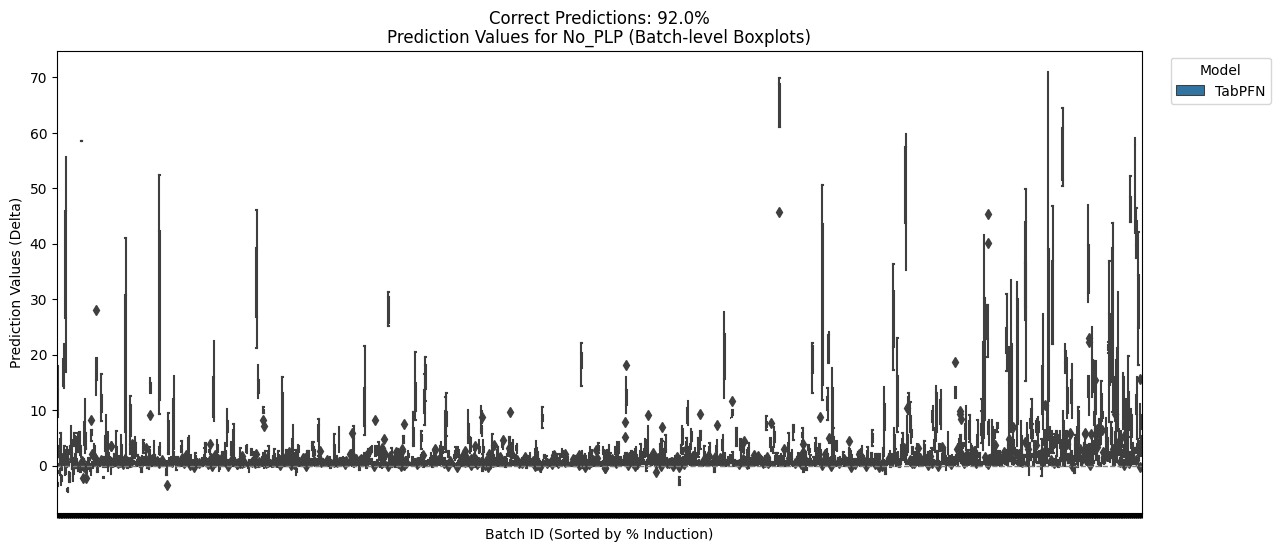

In [85]:
def plot_compounds_with_errors(df, features_filter="X_pca_harmony", percent_range=(0, 100), y_range=None, categories_to_display="all", models_to_display="all"): 
    """
    Plots the prediction errors (Delta) for all compounds using boxplots,
    with batch_id on the x-axis, grouped by models. The x-axis represents batch_id but is sorted by the true % induction.
    Incorrect predictions are flagged using statistical process control-style markers.

    Parameters:
        df (pd.DataFrame): DataFrame containing true values, predictions, models, and features.
        features_filter (str): Feature type to filter before plotting (e.g., "X_pca_harmony").
        percent_range (tuple): A range (min_percent, max_percent) to filter a percentage range of % induction.
        y_range (tuple): Optional tuple (min, max) to set y-axis limits.
        categories_to_display (list or str): List of PLP categories to display or "all" for all categories.
        models_to_display (list or str): List of models to display or "all" for all models.
    """
    
    # Filter DataFrame for the specified feature type
    df_filtered = df[df["Features"] == features_filter].copy()

    # Compute Prediction Error (Delta)
    df_filtered["Delta"] = np.sqrt(np.abs(df_filtered["Predicted Value"] - df_filtered["True Value"]))
    
     # Define PLP response categories
    def categorize_plp(response):
        if response > 80:
            return "High_PLP_10uM"
        elif response < 4.53:
            return "No_PLP"
        elif 4.53 <= response < 80:
            return "Low_PLP"
        else:
            return "High_PLP_10uM_nontoxic"
    
    df_filtered["PLP_Category_True"] = df_filtered["True Value"].apply(categorize_plp)
    df_filtered["PLP_Category_Predicted"] = df_filtered["Predicted Value"].apply(categorize_plp)
    
    # Determine whether the prediction matches the true category
    df_filtered["Prediction_Correct"] = df_filtered["PLP_Category_True"] == df_filtered["PLP_Category_Predicted"]
    
    # Filter by selected models
    if models_to_display != "all":
        df_filtered = df_filtered[df_filtered["Model"].isin(models_to_display)]
    
    # Apply percentage-based filtering
    min_val, max_val = df_filtered["True Value"].quantile([percent_range[0] / 100, percent_range[1] / 100])
    df_filtered = df_filtered[(df_filtered["True Value"] >= min_val) & (df_filtered["True Value"] <= max_val)]
    
    # Filter by selected categories
    if categories_to_display != "all":
        df_filtered = df_filtered[df_filtered["PLP_Category_True"].isin(categories_to_display)]
    
    # Sort batch_id based on True Value for consistent ordering
    df_filtered = df_filtered.sort_values("True Value").reset_index(drop=True)
    df_filtered["Sorted_Index"] = pd.factorize(df_filtered["batch_id"])[0]
    
    # Ensure batch_id remains categorical with the correct order
    df_filtered["batch_id"] = pd.Categorical(df_filtered["batch_id"], categories=df_filtered["batch_id"].unique(), ordered=True)
    
    # Create subplots for each selected category
    categories = df_filtered["PLP_Category_True"].unique()
    num_categories = len(categories)
    fig, axes = plt.subplots(num_categories, 1, figsize=(14, 6 * num_categories), sharex=False)
    
    if num_categories == 1:
        axes = [axes]  # Ensure axes is iterable for a single subplot
    
    for ax, category in zip(axes, categories):
        category_data = df_filtered[df_filtered["PLP_Category_True"] == category]
        sns.boxplot(data=category_data, x="Sorted_Index", y="Delta", hue="Model", ax=ax, width= 1.5)
        
        # Compute percentage of correct predictions
        correct_count = category_data["Prediction_Correct"].sum()
        total_count = len(category_data)
        correct_percentage = (correct_count / total_count) * 100 if total_count > 0 else 0
        
        # Add text annotation for correct prediction percentage
        ax.text(0.5, 1.05, f"Correct Predictions: {correct_percentage:.1f}%", fontsize=12, ha='center', va='bottom', transform=ax.transAxes)
        
        ax.set_title(f"Prediction Errors for {category} (Batch-level Boxplots)")
        ax.set_ylabel("Prediction Error (Delta)")
        ax.axhline(0, linestyle="--", color="gray", linewidth=1)
        ax.set_axisbelow(True)
        ax.grid(False)  # Remove background grid lines
        ax.set_xlabel("Batch ID (Sorted by % Induction)")
        ax.set_xticklabels([])
        ax.legend(title="Model", bbox_to_anchor=(1.02, 1), loc="upper left")
    
    plt.show()



plot_compounds_with_errors(predictions_df_filtered_simple, percent_range = (0,100), categories_to_display= ["No_PLP"], models_to_display= ["TabPFN"])

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_true_vs_predicted_with_models(df, features_filter="X_pca_harmony", top_n=20):
    """
    Plots the true and predicted values for the top N best-performing compounds, 
    including results from different models. The true value is displayed as a single
    black point per compound.

    Parameters:
        df (pd.DataFrame): DataFrame containing true values, predictions, models, and features.
        features_filter (str): Feature type to filter before plotting (e.g., "X_pca_harmony").
        top_n (int): Number of best-performing compounds to display.
    """

    # Filter DataFrame for the specified feature type
    df_filtered = df[df["Features"] == features_filter].copy()

    # Compute Prediction Error (Delta)
    df_filtered["Delta"] = df_filtered["Predicted Value"] - df_filtered["True Value"]

    # Group by Model and Compound, then average across Seeds
    df_avg = df_filtered.groupby(["Model", "Unnamed: 0"]).agg({"True Value": "mean", "Predicted Value": "mean"}).reset_index()

    # Compute absolute mean error per compound (irrespective of model) to rank best-performing
    compound_errors = df_avg.groupby("Unnamed: 0").apply(lambda x: (x["Predicted Value"] - x["True Value"]).abs().mean()).reset_index()

    # Ensure correct column naming
    compound_errors.columns = ["Unnamed: 0", "Error"]

    # Select the top N best-performing compounds (lowest absolute error)
    top_compounds = compound_errors.nsmallest(top_n, "Error")["Unnamed: 0"]

    # Filter dataset to only include top compounds
    df_top = df_filtered[df_filtered["Unnamed: 0"].isin(top_compounds)]  # Keep all seeds

    # Reshape DataFrame for plotting predicted values
    df_melted = df_top.melt(id_vars=["Model", "Unnamed: 0"], value_vars=["Predicted Value"],
                            var_name="Type", value_name="Value")

    # Create a boxplot for predicted values, grouped by Model and Compound
    plt.figure(figsize=(14, 6))
    ax = sns.boxplot(data=df_melted, x="Unnamed: 0", y="Value", hue="Model", palette="Set2", dodge=True)

    # Extract true values (one per compound, averaged across seeds)
    true_values = df_top.groupby("Unnamed: 0")["True Value"].mean().reset_index()

    # Overlay scatter plot for true values (one black point per compound at the center)
    for i, compound in enumerate(top_compounds):
        true_value = true_values[true_values["Unnamed: 0"] == compound]["True Value"].values
        if len(true_value) > 0:
            ax.scatter([i] * len(true_value), true_value, color="black", marker="D", zorder = 2, s=100, label="True Value" if i == 0 else "")

    # Format Plot
    plt.xticks(rotation=45, ha="right")
    plt.xlabel("Compound")
    plt.ylabel("Value")
    plt.title(f"True vs Predicted Values for Top {top_n} Best-Performing Compounds ({features_filter})")
    plt.legend(title="Model", bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.grid(True, linestyle="--", alpha=0.5)

    plt.show()

# Example Usage (Ensure df_predictions is loaded first)
plot_true_vs_predicted_with_models(predictions_df_filtered_simple, features_filter="X_pca_harmony", top_n=20)


KeyError: 'Unnamed: 0'

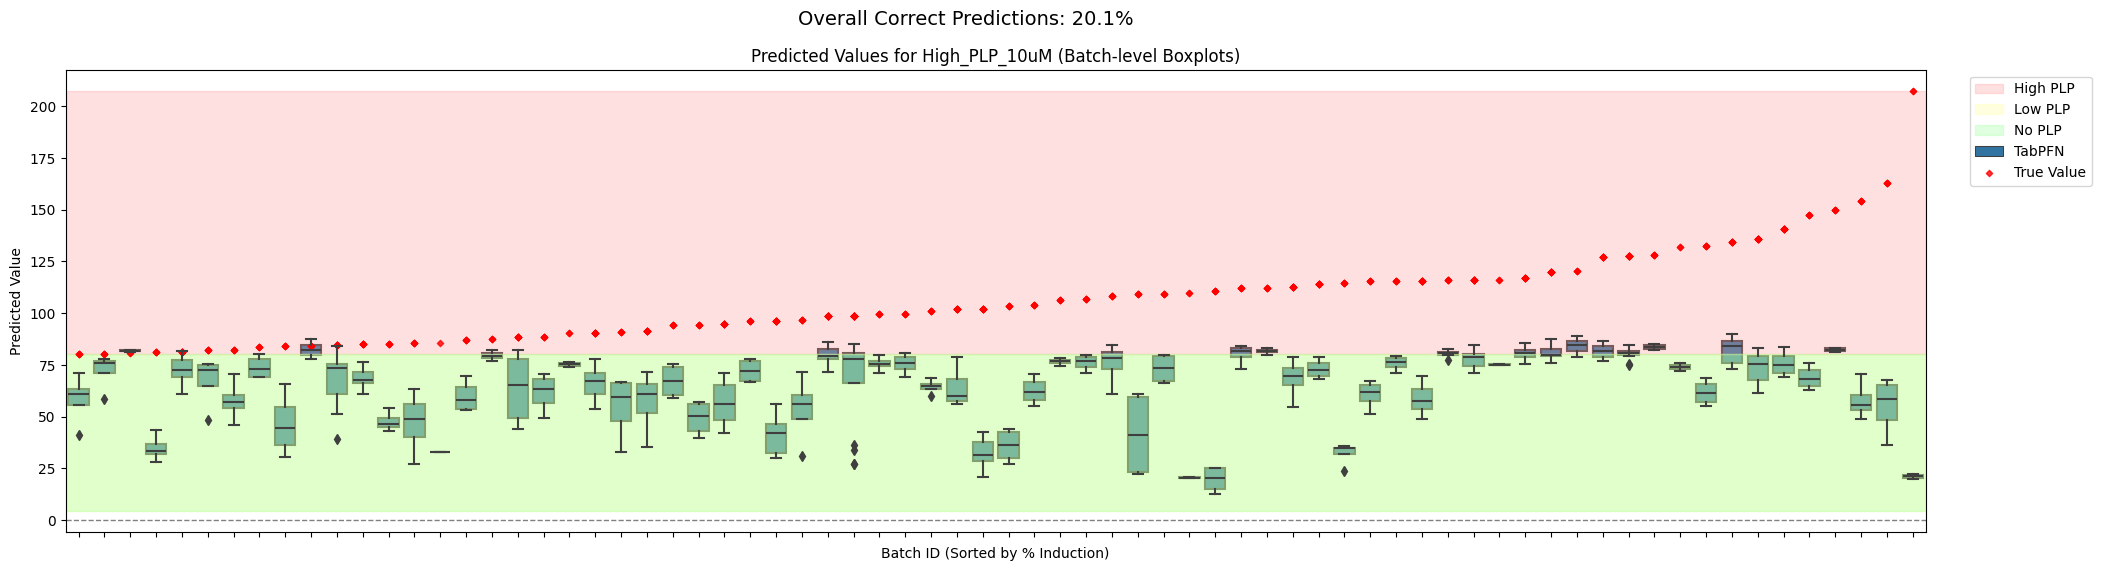

In [97]:
def plot_compounds_with_predictions(df, features_filter="X_pca_harmony", percent_range=(0, 100), y_range=None, categories_to_display="all", models_to_display="all"): 
    """
    Plots the predicted values for all compounds using boxplots,
    with batch_id on the x-axis, grouped by models. The x-axis represents batch_id but is sorted by the true % induction.
    True values are marked with red rhombs.

    Parameters:
        df (pd.DataFrame): DataFrame containing true values, predictions, models, and features.
        features_filter (str): Feature type to filter before plotting (e.g., "X_pca_harmony").
        percent_range (tuple): A range (min_percent, max_percent) to filter a percentage range of % induction.
        y_range (tuple): Optional tuple (min, max) to set y-axis limits.
        categories_to_display (list or str): List of PLP categories to display or "all" for all categories.
        models_to_display (list or str): List of models to display or "all" for all models.
    """
    
    # Filter DataFrame for the specified feature type
    # Filter DataFrame for the specified feature type
    df_filtered = df[df["Features"] == features_filter].copy()
    
    # Define PLP response categories
    def categorize_plp(response):
        if response > 80:
            return "High_PLP_10uM"
        elif response < 4.53:
            return "No_PLP"
        elif 4.53 <= response < 80:
            return "Low_PLP"
        else:
            return "High_PLP_10uM_nontoxic"
    
    df_filtered["PLP_Category_True"] = df_filtered["True Value"].apply(categorize_plp)
    df_filtered["PLP_Category_Predicted"] = df_filtered["Predicted Value"].apply(categorize_plp)
    
    # Determine whether the prediction matches the true category
    df_filtered["Prediction_Correct"] = df_filtered["PLP_Category_True"] == df_filtered["PLP_Category_Predicted"]
    
    # Filter by selected models
    if models_to_display != "all":
        df_filtered = df_filtered[df_filtered["Model"].isin(models_to_display)]
    
    # Apply percentage-based filtering
    min_val, max_val = df_filtered["True Value"].quantile([percent_range[0] / 100, percent_range[1] / 100])
    df_filtered = df_filtered[(df_filtered["True Value"] >= min_val) & (df_filtered["True Value"] <= max_val)]
    
    # Filter by selected categories
    if categories_to_display != "all":
        df_filtered = df_filtered[df_filtered["PLP_Category_True"].isin(categories_to_display)]
    
    # Sort batch_id based on True Value for consistent ordering
    df_filtered = df_filtered.sort_values("True Value").reset_index(drop=True)
    df_filtered["Sorted_Index"] = pd.factorize(df_filtered["batch_id"])[0]
    
    # Ensure batch_id remains categorical with the correct order
    df_filtered["batch_id"] = pd.Categorical(df_filtered["batch_id"], categories=df_filtered["batch_id"].unique(), ordered=True)
    
    # Compute overall prediction correctness percentage
    correct_percentage = df_filtered["Prediction_Correct"].mean() * 100
    
    # Create subplots for each selected category
    categories = df_filtered["PLP_Category_True"].unique()
    num_categories = len(categories)
    fig, axes = plt.subplots(num_categories, 1, figsize=(24, 6 * num_categories), sharex=False)
    fig.suptitle(f"Overall Correct Predictions: {correct_percentage:.1f}%", fontsize=14)
    
    if num_categories == 1:
        axes = [axes]  # Ensure axes is iterable for a single subplot
    
    for ax, category in zip(axes, categories):
        category_data = df_filtered[df_filtered["PLP_Category_True"] == category]
        
        # Add horizontal background shading for different % induction ranges
        ax.axhspan(80, df_filtered["True Value"].max(), color="#ff9999", alpha=0.3, label="High PLP")
        ax.axhspan(4.53, 80, color="#ffff99", alpha=0.3, label="Low PLP")
        ax.axhspan(df_filtered["True Value"].min(), 4.53, color="#99ff99", alpha=0.3, label="No PLP")
        
        sns.boxplot(data=category_data, x="Sorted_Index", y="Predicted Value", hue="Model", ax=ax, dodge=True)
        
        # Add scatter plot for True Values
        ax.scatter(category_data["Sorted_Index"], category_data["True Value"], color='red', marker='D', s=10, label='True Value', alpha=0.8)
        
        ax.set_title(f"Predicted Values for {category} (Batch-level Boxplots)")
        ax.set_ylabel("Predicted Value")
        ax.axhline(0, linestyle="--", color="gray", linewidth=1)
        ax.set_axisbelow(True)
        ax.grid(False)  # Remove background grid lines
        if y_range:
            ax.set_ylim(y_range)
        ax.set_xlabel("Batch ID (Sorted by % Induction)")
        ax.set_xticklabels([])
        ax.legend(title="", bbox_to_anchor=(1.02, 1), loc="upper left")
    
    plt.show()

plot_compounds_with_predictions(predictions_df_filtered_simple, percent_range = (0,100), categories_to_display= ["High_PLP_10uM"], models_to_display= ["TabPFN"])